# Final Project: Dinosaur Park
File: DinosaurPark.txt

This file contains a dataset describing ticket sales at a dinosaur park. 

## 1.0 Preparing Jupyter Notebook

### Package Downloads

In [1]:
#Import necessary packages and set options for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Jupyter Notebook Settings

In [2]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns',100)

### Function Creation

#### Graphing Functions

In [3]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [4]:
#Create a scatterplot graph
def scatter(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(14,6))
    plt.scatter(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#### Seasonality Functions

In [5]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
#Create a rolling mean of the data to understand the trend

def roll_mean(df_column,window,title,xlabel,ylabel):

    plt.figure(figsize=(10,6))
    rolmean = df_column.rolling(window).mean()

    # Plot the original data and the rolling mean
    plt.figure(figsize=(10, 6))
    plt.plot(df_column, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean (window={window})')

    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend and display plot
    plt.legend(loc='best')
    plt.show()

In [7]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

#### Least Squares Functions

In [8]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.plot(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

def get_least_squares_line(x_value, y_value):
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Getting the coefficients of the least squares line
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

In [10]:
def calculate_residuals(x_value, y_value, slope, intercept):
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Predicting y values using the provided slope and intercept
    y_pred = slope * x + intercept

    # Calculating residuals
    residuals = y - y_pred

    return residuals

#### ARIMA Modeling Functions

In [11]:
#Create the Dickey Fuller test to use on data
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [12]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [13]:
def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

#### Forecasting Functions

In [14]:
def test_training_model(train_data, test_data, predictions,
                        x_label, y_label, title,prediction_label):
    # Plot original data
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data['Sales'], label='Train Data', color='cornflowerblue')
    plt.plot(test_data.index, test_data['Sales'], label='Test Data', color='mediumseagreen')
    plt.plot(predictions.index, predictions, label=prediction_label, color='darkorange',linestyle='--')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()


In [15]:
def model_forecast(original_data, original_data_sales, predictions,
                        x_label, y_label, title, prediction_label):
    # Plot original data
    plt.figure(figsize=(10, 6))
    plt.plot(original_data.index, original_data_sales, label='Original Data', color='cornflowerblue')
    plt.plot(predictions.index, predictions, label=prediction_label, color='mediumseagreen', linestyle='--')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()


## 1.1 Data Preprocessing:
Load the dataset and convert the date information into a datetime object to facilitate time series analysis.

Check for missing values and anomalies, and handle them appropriately.

### Import data

In [16]:
#Import the dinosaur data and save it as dinosaur 
dinosaur = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Applied Statistics & Modeling/Final Project/Data Files/DinosaurPark.txt')
dinosaur 

,YEAR,MONTH,SALES
0,1992,1,3253
1,1992,2,3042
2,1992,3,3246
3,1992,4,3164
4,1992,5,3210
...,...,...,...
127,2002,8,7489
128,2002,9,6821
129,2002,10,7032
130,2002,11,8310


The year and month columns need to be converted into a datetime format so that further analysis can be performed. 

### Preprocess dataframe

In [17]:
#Convert the year and month columns to datetime

#Create a column of 1's to have it as the first day of the month
Day = np.ones(len(dinosaur))
dinosaur['DAY'] = Day

#Create the date column
date = pd.to_datetime(dinosaur[['YEAR','MONTH','DAY']])
dinosaur['Date'] = date
dinosaur

,YEAR,MONTH,SALES,DAY,Date
0,1992,1,3253,1.0,1992-01-01
1,1992,2,3042,1.0,1992-02-01
2,1992,3,3246,1.0,1992-03-01
3,1992,4,3164,1.0,1992-04-01
4,1992,5,3210,1.0,1992-05-01
...,...,...,...,...,...
127,2002,8,7489,1.0,2002-08-01
128,2002,9,6821,1.0,2002-09-01
129,2002,10,7032,1.0,2002-10-01
130,2002,11,8310,1.0,2002-11-01


In [18]:
#Drop the unncessary columns 
dinosaur.drop(columns={'YEAR','MONTH','DAY'},inplace=True)

In [19]:
#Rename column names
dinosaur.rename(columns={'SALES':'Sales'},inplace=True)

In [20]:
#Set the index of dataframe to date
dinosaur.set_index('Date',inplace=True)

#Create a copy of the original data frame
dinosaur_copy = dinosaur.copy()

dinosaur

,Sales
Date,
1992-01-01,3253
1992-02-01,3042
1992-03-01,3246
1992-04-01,3164
1992-05-01,3210
...,...
2002-08-01,7489
2002-09-01,6821
2002-10-01,7032


In [21]:
#Double check the columns are in the right format
#Expect '<M8[ns]' for index
#Expect 'float64' or 'int64' for monthly mean
print('Date dtype: ',dinosaur.index.dtype)
print('')
print('Daily Visitors dtype: ',dinosaur['Sales'].dtype)

Date dtype:  datetime64[ns]

Daily Visitors dtype:  int64


### Check for Missing Values

In [22]:
#Use isna is to create a series of true and false
#sum those to get a total number of missing values
#if it is 0 you can continue
dinosaur['Sales'].isna().sum()

0

### Check for Anomalies
There are a number of ways to do this. I am going to use the statistical format of creating z scores and see if any of them life outside a standard deviation zscore of 3.

In [23]:
#Create zscore value
dinosaur['zscore'] = (dinosaur['Sales'] - dinosaur['Sales'].mean()) / dinosaur['Sales'].std()

#Identify anomalies where their standard deviation is greater than 3
anomalies = dinosaur[abs(dinosaur['zscore']) > 3]

if len(anomalies) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected:")
    print(anomalies)

Anomalies detected:
            Sales    zscore
Date                       
1999-12-01  11020  3.062911
2000-12-01  11050  3.080684
2001-12-01  12042  3.668366
2002-12-01  12144  3.728793


The anomalies happen on a consistient basis (the 12 month), this means that the data should not be removed as it is a part of the pattern of the data.

### Plot the scatterplot graph

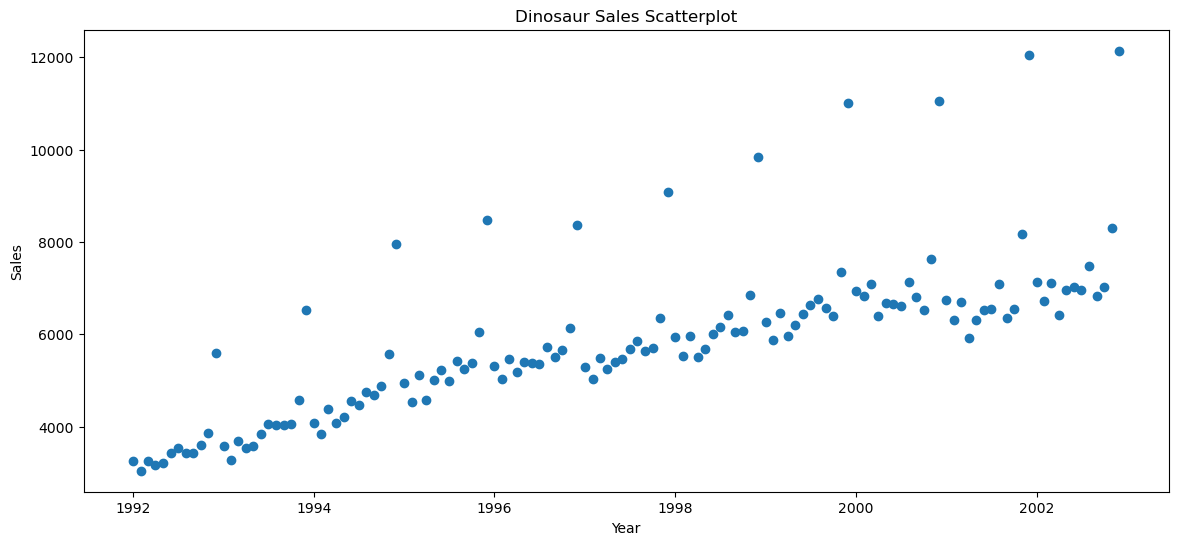

In [95]:
scatter(dinosaur.index,dinosaur['Sales'],'Dinosaur Sales Scatterplot','Year','Sales')

There is an equal spread of data and there is enough variation to where aggregation is not required. The anomalies look appropriate with the data and will be an important factor of the time series that is going to be further explored.

## 1.2 Exploratory Data Analysis: 
Visualize the data to understand trends, seasonality, and other characteristics.

Decompose the series to observe its components: trend, seasonality, and residuals.

### Visualise the data

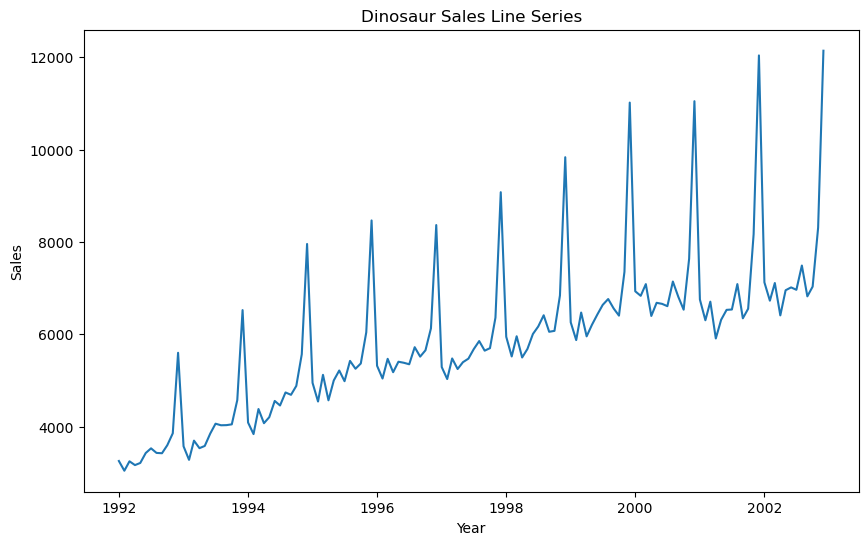

In [96]:
#Plot the time series graph of website visits data
time_series(dinosaur.index,dinosaur['Sales'],'Dinosaur Sales Line Series','Year','Sales')

This data seems to have trends and seasonality which can be explored using seasonal decomposition. The greatest point of interest is the observation of the large spike that happens on a reoccuring basis.

### Exploration of Seasonal Decomposition of Dinosaur Sales

#### Seasonality Period Decision
There is a seasonal period to the data, there are a few ways to find it.
1. Visualisation
2. ACF & PACF Plots

##### 1. Visualisation of Seasonality Period Decision
To have a greater understanding of the data and its seasonal period, I am going to take a smaller portion of the data to see the frequency.

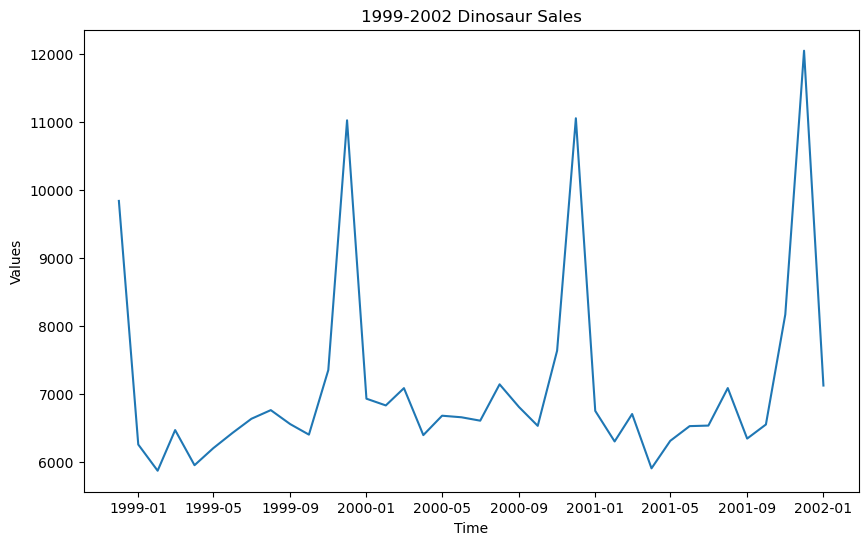

In [26]:
#Create a rolling mean graph of the data
dinosaur_time_period_1 = pd.DataFrame(dinosaur['Sales'].loc['1998-12-01':'2002-01-01'])
time_series(dinosaur_time_period_1.index,dinosaur_time_period_1['Sales'],'1999-2002 Dinosaur Sales','Time','Values')

The seasonal pattern can be observed a little easier when looking at the most recent data. The values are increasing and the spikes are also increasing at a similar rate. The values in between the spikes seem to be quite sporadic and do not show any real values. This is likely that dinosaur sales perform best in December than any other month

##### 2. ACF & PACF Plots
ACF plot - Is looking at the moving average nature of the graph, this is how much values from lag k-1 impact lag k.

PACF plot - Is looking at the autoregressive nature of the graph, this is how values from lag k impact the current value

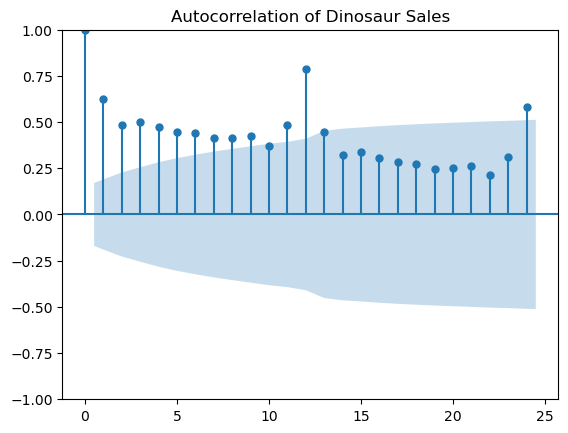

In [27]:
#Look at the acf plot to help determine the seasonal period
dinosaur_acf = plot_acf(dinosaur['Sales'],title= 'Autocorrelation of Dinosaur Sales',lags=24)

There is a relatively high autocorrelation for dinosaur sales which means that there is a moving average component (q). The largest spikes occur at 12 and 24 which suggests that the seasonal value is likely to be 12.

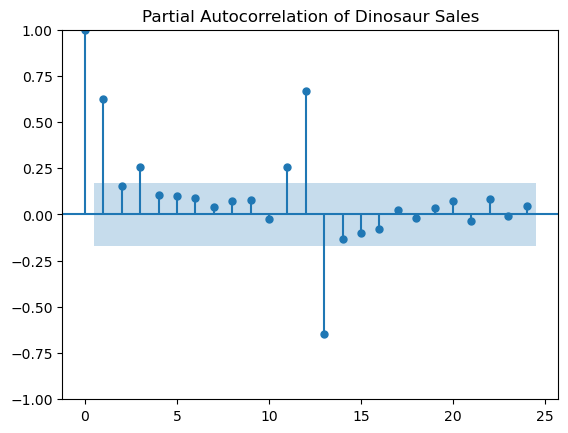

In [28]:
#Look at the pacf plot to help determine the seasonal period
dinosaur_pacf = plot_pacf(dinosaur['Sales'],title= 'Partial Autocorrelation of Dinosaur Sales',lags=24)

The partial autocorrelation shows values at 12 and 13 to be the highest. The value at 12 makes sense and is going to further be a reason for choosing a yearly seasonal period as each 12 months there is a common value. 13 lags is likely also very similar as it drops down to a pretty similar level each year.

### Seasonal Decomposition of Dinosaur
Using a period of 1 year (12 months), break down the data into its individual series.

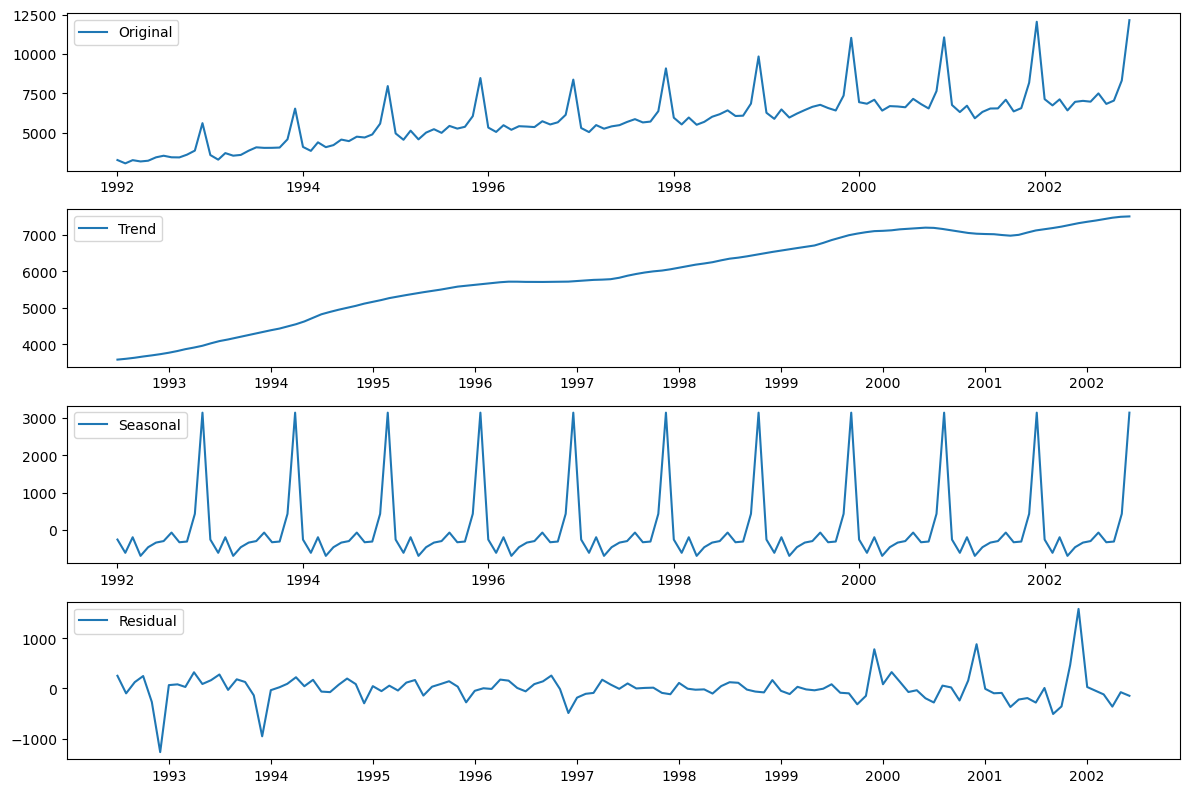

In [29]:
#Create a variable which can be referrenced to get each of the different series
#Plot the decomposition with a period of 1 year (12 instances)
dinosaur_seasonal_decomposition = decompose_seasonality(dinosaur['Sales'],12)
plot_seasonal_decomposition(dinosaur['Sales'],(12))

#### Trend of Dinosaur
There is a clear trend that is observed in the series above. This is increasing from 1992 to 2002. Not only is there a trend in the overall movement of the data but there is also a trend in the spikes, this will be further explored below.

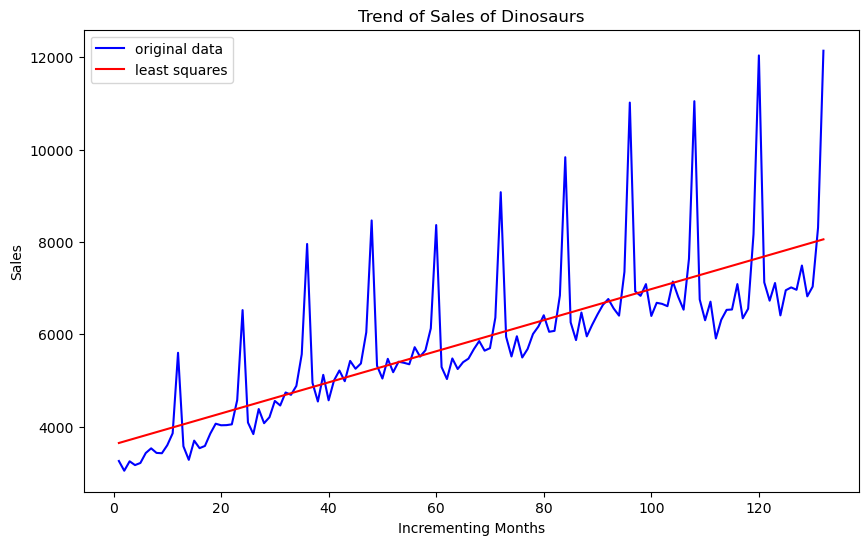

In [97]:
#Create an incrementing months columns so that a line of best fit can go through the data
dinosaur['Incrementing Month'] = range(1,len(dinosaur)+1)

#plot the original data with the least squares line
plot_least_squares_line(dinosaur['Incrementing Month'],dinosaur['Sales'],'Trend of Sales of Dinosaurs','Incrementing Months','Sales')

##### Evaluation of Dinosaur Sales
Using the mean absolute error look at how far away the values are from the least squares line.

In [31]:
#Get the equation for the least squares line
slope_original = get_least_squares_line(dinosaur['Incrementing Month'],dinosaur['Sales'])[0]
intercept_original = get_least_squares_line(dinosaur['Incrementing Month'],dinosaur['Sales'])[1]
get_least_squares_line(dinosaur['Incrementing Month'],dinosaur['Sales'])

(33.69147104402228, 3609.3580846634272)

In [32]:
#Create a series of values which is the length of the original data
dinosaur['Least Squares Value Original'] = intercept_original + slope_original*dinosaur['Incrementing Month']

In [33]:
#Find the MAE for dinosaur sales without any changes
mae_original = mean_absolute_error(dinosaur['Sales'],dinosaur['Least Squares Value Original'])
mae_original

649.2980631109032

The line of best is slightly above the data values from months 1-11. I am going to split the data so that each trend can be explored.
1. Monthly values from 1-11 cyclically throughout the data
2. Monthly value of 12, which is December

#### 1. Monthly values of 1-11

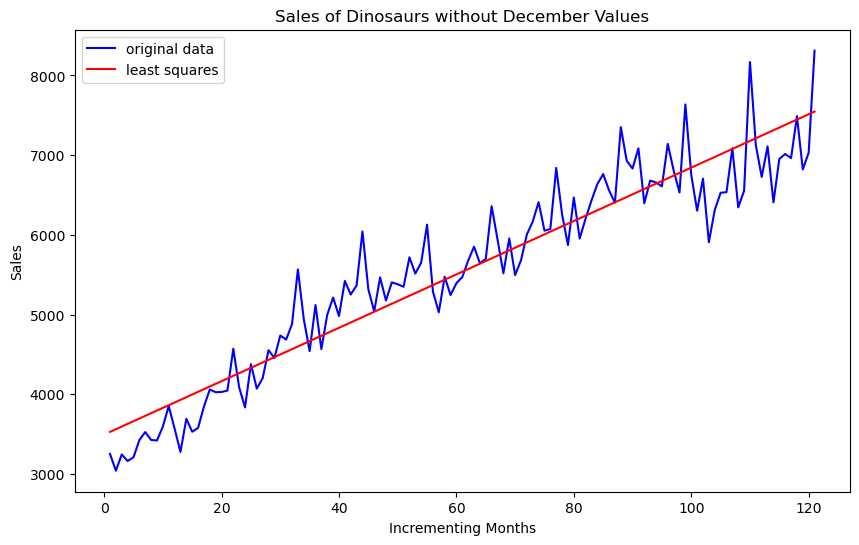

In [34]:
#Remove every December value from the dataset
dinosaur_no_december = dinosaur_copy.drop(dinosaur.index[11::12], inplace=False)

#Create an incrementing month
dinosaur_no_december['Incrementing Month'] = range(1,len(dinosaur_no_december)+1) 

plot_least_squares_line(dinosaur_no_december['Incrementing Month'],dinosaur_no_december['Sales'],'Sales of Dinosaurs without December Values','Incrementing Months','Sales')

##### Evaluation of Dinosaur Sales
Use the mean absolute error again to find the difference between line of best fit and the data without december

In [35]:
#Get the equation for the least squares line of dinosaur sales with no december values
slope_no_december = get_least_squares_line(dinosaur_no_december['Incrementing Month'],dinosaur_no_december['Sales'])[0]
intercept_no_december = get_least_squares_line(dinosaur_no_december['Incrementing Month'],dinosaur_no_december['Sales'])[1]
get_least_squares_line(dinosaur_no_december['Incrementing Month'],dinosaur_no_december['Sales'])

(33.48100528383687, 3495.675206611571)

In [36]:
#Create a series of values which is the length of the original data
dinosaur_no_december['Least Squares Value No December'] = intercept_no_december + slope_no_december*dinosaur_no_december['Incrementing Month']

#Find the MAE for dinosaur sales with no december values
mae_no_december = mean_absolute_error(dinosaur_no_december['Sales'],dinosaur_no_december['Least Squares Value No December'])
mae_no_december

320.78957385558857

The mae is about half of the mae from the original values. This shows how much the 12th value changed the accuracy of the model. The final step is to do a regression analysis on the values in December.

#### 2. Monthly value of 12

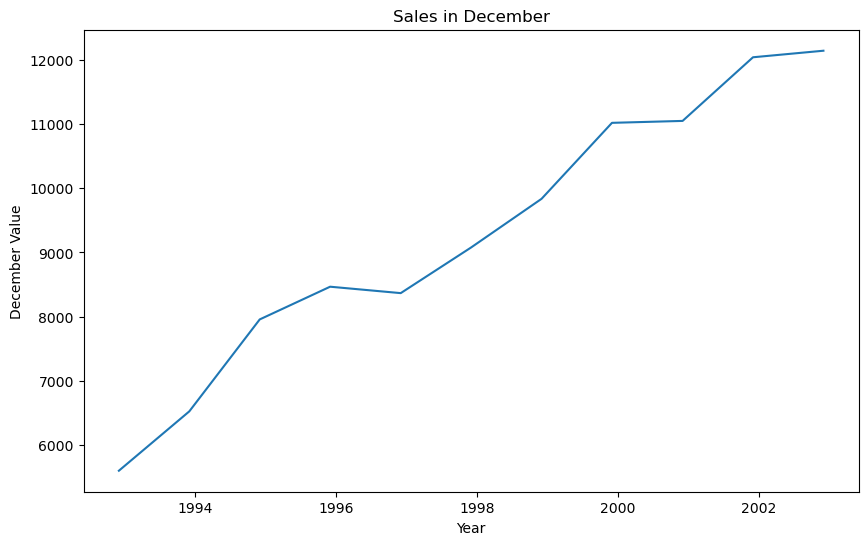

In [37]:
#Create a dataframe which looks at every 12th value
december_values = pd.DataFrame(dinosaur['Sales'].iloc[11::12])
december_values['Incrementing Year'] = range(1,len(december_values)+1)
time_series(december_values.index,december_values['Sales'],'Sales in December','Year','December Value')

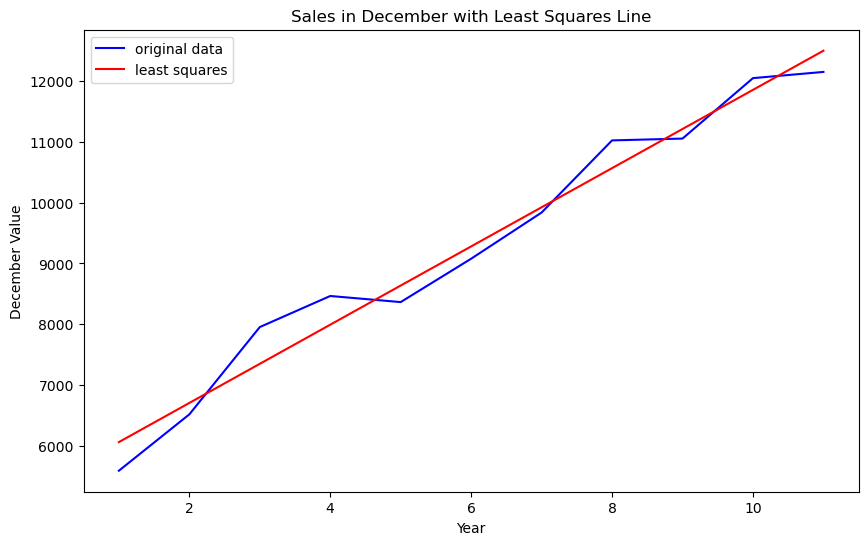

In [38]:
#Plot a least squares line against the trend of the yearly December values
plot_least_squares_line(december_values['Incrementing Year'],december_values['Sales'],'Sales in December with Least Squares Line','Year','December Value')

In [39]:
#Get the least square line equation
slope_december_values = get_least_squares_line(december_values['Incrementing Year'],december_values['Sales'])[0]
intercept_december_values = get_least_squares_line(december_values['Incrementing Year'],december_values['Sales'])[1]
get_least_squares_line(december_values['Incrementing Year'],december_values['Sales'])

(642.4181818181822, 5425.399999999997)

In [40]:
#Create a series of values which is the length of the december only sales
december_values['Least Squares Value December Values'] = intercept_december_values + slope_december_values*december_values['Incrementing Year']

#Find the MAE for only the december values for dinosaur sales
mae_december = mean_absolute_error(december_values['Sales'],december_values['Least Squares Value December Values'])
mae_december

313.08099173553705

##### Comparison of different MAE values
Doing this should help proves that breaking up the data into its two segments and performing two different least square lines should be more accurate than one. This can be used later on when forecasting future values.

In [41]:
print(f'MAE Original Values {mae_original}')
print(f'MAE No December Values {mae_no_december}')
print(f'MAE December Values {mae_december}')

MAE Original Values 649.2980631109032
MAE No December Values 320.78957385558857
MAE December Values 313.08099173553705


#### Seasonal of Dinosaur Sales

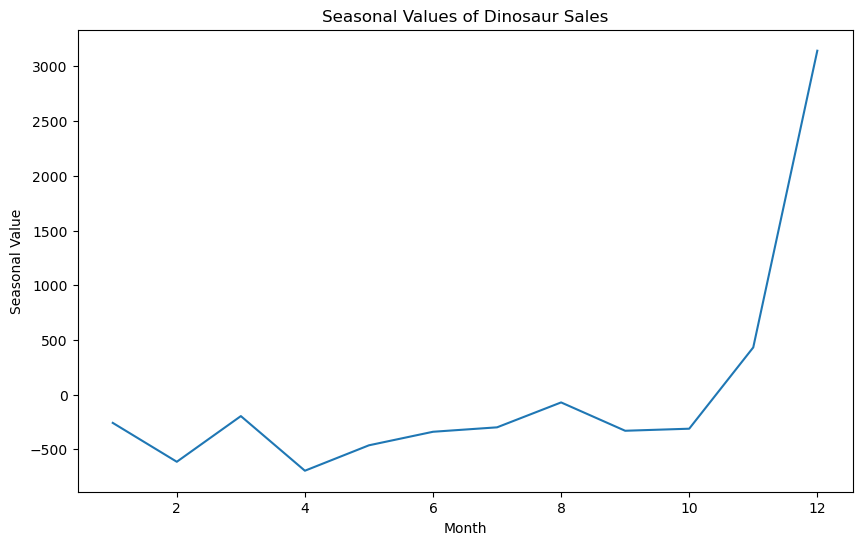

In [42]:
dinosaur_seasonal_values = pd.DataFrame(dinosaur_seasonal_decomposition[2].iloc[0:12])
dinosaur_seasonal_values['Incrementing Month'] = range(1,len(dinosaur_seasonal_values)+1)
time_series(dinosaur_seasonal_values['Incrementing Month'],dinosaur_seasonal_values['seasonal'],'Seasonal Values of Dinosaur Sales','Month','Seasonal Value')

From the seasonal decomposition, there is a clear seasonal period over a month period (1 year). This graph shows the average increase or decrease for the month of the year. Notice that month 12 is the only substaintial difference.

#### Residual of Dinosaur

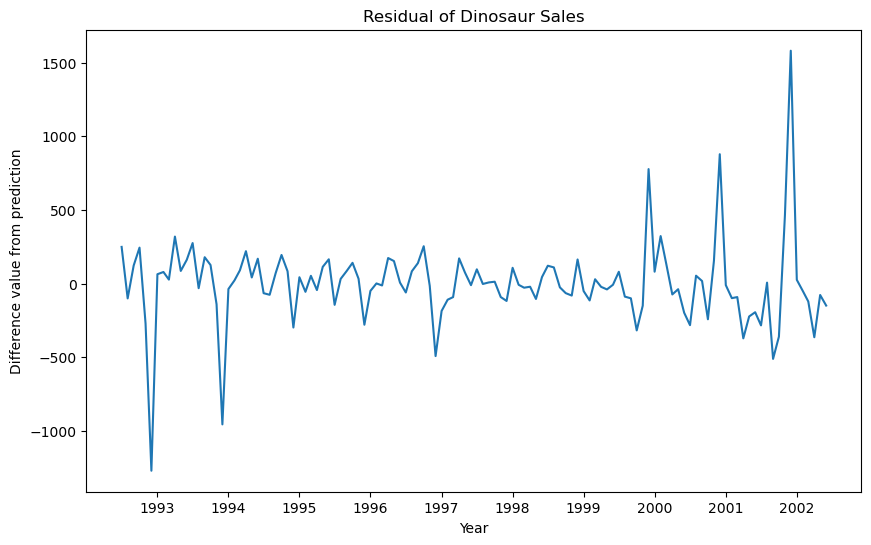

In [43]:
#Plot the residual of dinosaur sales
time_series(dinosaur_seasonal_decomposition[3].index,dinosaur_seasonal_decomposition[3],'Residual of Dinosaur Sales','Year','Difference value from prediction')

When you take the residual or the difference value from the combination of the seasonal and trend values from the decomposition you get a residual plot of the above. This demonstrates how the 12th value increases as time goes on as the spikes start negative and end very positive even with a constant seasonal spike. This suggests that there is a multiplicative nature to the growth of that 12 month value.

In [44]:
#Remove the seasonal values from the dinosaur sales
dinosaur_seasonally_adjusted = pd.DataFrame(dinosaur_seasonal_decomposition[0] - dinosaur_seasonal_decomposition[2])
dinosaur_seasonally_adjusted.rename(columns={dinosaur_seasonally_adjusted.columns[0]:'Value'},inplace=True)
dinosaur_seasonally_adjusted

,Value
Date,
1992-01-01,3510.861458
1992-02-01,3655.298958
1992-03-01,3441.886458
1992-04-01,3859.073958
1992-05-01,3672.765625
...,...
2002-08-01,7559.957292
2002-09-01,7150.911458
2002-10-01,7343.128125


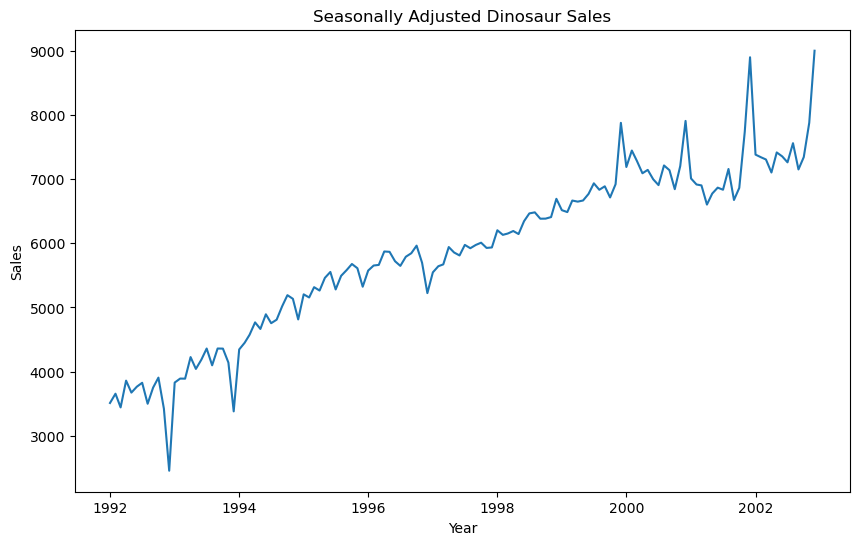

In [45]:
#Plot the seasonally adjusted dinosaur sales to see the the outcome of the graph without seasonal impacts.
time_series(dinosaur_seasonally_adjusted.index,dinosaur_seasonally_adjusted['Value'],'Seasonally Adjusted Dinosaur Sales','Year','Sales')

After removing the seasonality, the same observation can be observed as was seen in the residual values. There seems to be another aspect of the graph that is increasing at a different rate than the rest. The 12th month is increasing ontop of the overall increasing trend. Need to adjust for this in forecasting by looking at the trend of the 12th values.

## 1.3 ARIMA Model Building:

1. Determine the order of differencing (d) needed to make the series stationary.

2. Identify the autoregressive term (p) and moving average term (q) using plots such as the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

3. Construct and fit the ARIMA model to the historical data.

#### ARIMA Modeling
The following ARIMA modeling types are going to be explored
- AR: Autoregressive Model (p value - using PACF to find order)
- MA: Moving Average Model (q value - using ACF to find order)
- ARMA: Autoregressive Moving Average (p value, q value)
- ARIMA: Autoregressive Integrated Moving Average (p value, d value, q value)
- SARIMA: Seasonal Autoregressive Integrated Moving Average (p value, d value, q value, P value, D value, Q value, seasonal). P value found through seasonal PACF, D value found through seasonal ADF statistic, Q value found through seasonal ACF

#### p,d,q values

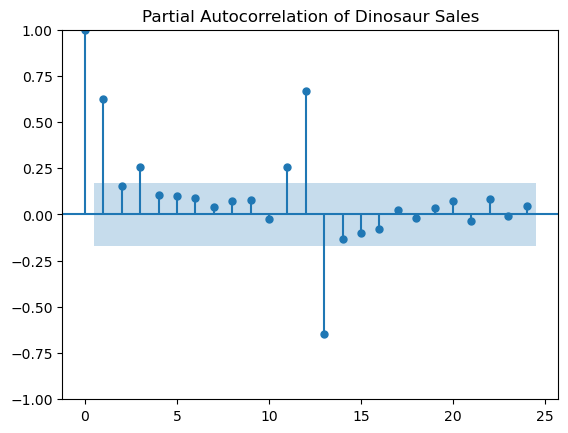

In [46]:
#Use the pacf plot to find the p model
dinosaur_pacf

In [47]:
#Create a list of p orders for dinosaur sales
p_orders_value = [1,3,12]

In [48]:
#Difference the data to a second degree to ensure that the graph is stationary
dinosaur['First Difference'] = dinosaur['Sales'].diff()
dinosaur['Second Difference'] = dinosaur['First Difference'].diff()

In [49]:
#Look at the ADF statistic of the first difference
dinosaur_copy_1 = dinosaur[1:]
adf_test(dinosaur_copy_1['First Difference'])

ADF Statistic:  -2.9748113064660893
P-Value:  0.03731460738055275
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [50]:
#Look at the ADF statistic for the second difference
dinosaur_copy_2 = dinosaur_copy_1[1:]
adf_test(dinosaur_copy_2['Second Difference'])

ADF Statistic:  -11.727173081010706
P-Value:  1.3687841295731867e-21
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [51]:
#From the differencing you could take the first or the second difference for models
d_orders = [1,2]

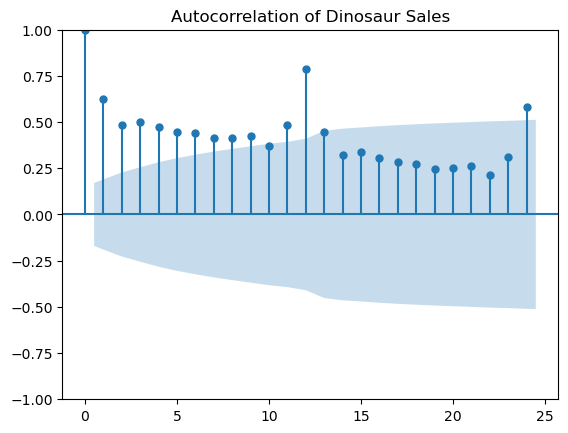

In [52]:
#Use the acf plot to find the q model
dinosaur_acf

In [53]:
#List the q orders for dinosaur sales
q_orders_value = [1,12]

#### P,D,Q Values

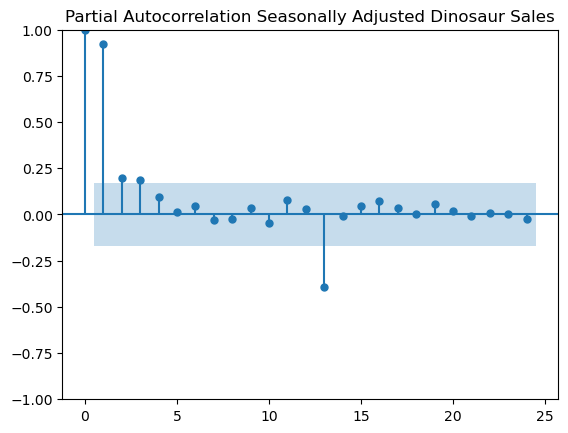

In [54]:
#Use the seasonally adjusted pacf to find P value
dinosaur_seasonally_adjusted_pacf = plot_pacf(dinosaur_seasonally_adjusted,title='Partial Autocorrelation Seasonally Adjusted Dinosaur Sales',lags=24)

In [55]:
#Create a list of P orders
P_orders_value = [1,13]

In [56]:
#Look at the ADF statistic to find D values
adf_test(dinosaur_seasonally_adjusted)

ADF Statistic:  -1.9682637697112113
P-Value:  0.3006592939358801
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [57]:
#Take the two differences as see how the adf statistic decreases
dinosaur_seasonally_adjusted['First Difference'] = dinosaur_seasonally_adjusted['Value'].diff()
dinosaur_seasonally_adjusted['Second Difference'] = dinosaur_seasonally_adjusted['First Difference'].diff()

In [58]:
#Print each adf statistic for the first and then the second difference
dinosaur_sa_copy_1 = dinosaur_seasonally_adjusted[1:]
adf_test(dinosaur_sa_copy_1['First Difference'])
dinosaur_sa_copy_2 = dinosaur_sa_copy_1[1:]
adf_test(dinosaur_sa_copy_2['Second Difference'])

ADF Statistic:  -3.4520973482138215
P-Value:  0.00930601119513897
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58
ADF Statistic:  -8.539582577294555
P-Value:  9.86596600940754e-14
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [59]:
#Create a list of D orders
D_orders_value = [1,2]

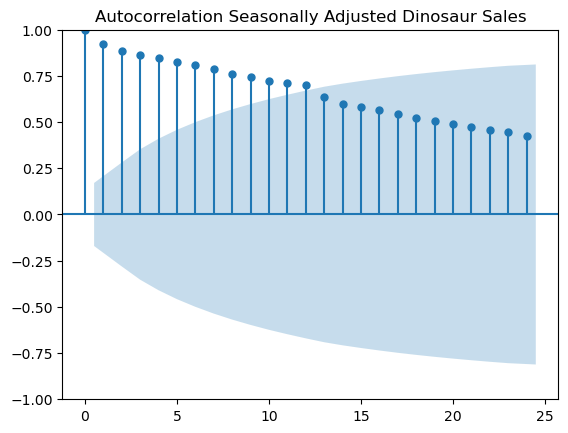

In [98]:
#Use the ACF plot to find the Q value
dinosaur_seasonally_adjusted_acf = plot_acf(dinosaur_seasonally_adjusted['Value'],title='Autocorrelation Seasonally Adjusted Dinosaur Sales',lags=24)

In [61]:
#Create a list of Q orders
Q_orders_value = [1,2]

#### ARIMA/SARIMA Model Evaluation

In [62]:
#Create a list of different ARIMA models to choose from
evaluate_time_series_models(dinosaur['Sales'],p_orders_value,q_orders_value,d_orders)

,Model,Order,AIC,BIC
19,ARIMA,"(12, 1, 1)",1864.071460,1904.324222
21,ARIMA,"(12, 2, 1)",1866.141284,1906.286766
10,ARMA,"(12, 0, 12)",1885.061289,1960.014139
9,ARMA,"(12, 0, 1)",1993.021178,2036.263207
20,ARIMA,"(12, 1, 12)",2039.007024,2110.886957
22,ARIMA,"(12, 2, 12)",2048.009196,2119.697557
2,AR,"(12, 0, 0)",2052.195855,2092.555082
16,ARIMA,"(3, 1, 12)",2152.279864,2198.283021
12,ARIMA,"(1, 1, 12)",2153.848926,2194.101688
4,MA,"(0, 0, 12)",2170.377692,2210.736919


In [63]:
#Select best SARIMA model outcome
select_best_sarima_model(dinosaur['Sales'],p_orders_value,d_orders,q_orders_value,P_orders_value,D_orders_value,Q_orders_value,12)

{'aic': 1618.6061329683816,
 'bic': 1626.9435034477162,
 'pdq': (0, 1, 2),
 'seasonal_pdq': (0, 1, 0, 12)}

### ARIMA/SARIMA Model Selection Comments
Upon talking with my professor it was recommended to not above an order of 5 for p and q values. This is field practice and it is due to the fact that when you go above that you are looking more into seasonality (such as 12 as seen above) rather than solely a moving average and autoregressive nature. Looking at the ACF and PACF can help identity the seasonal value which when used as 12 in the SARIMA model selection results in the p and P to be 0 as there is no autoregressive nature but there is a moving average relationship. I am going to include one complicated ARIMA model (12,1,1) as well as the least complicated one which is highest on list, which is ARIMA (1,1,1) in this case. The role of the ARIMA modeling is not to find the best but to find around the best so that it is not over complicated and leads to a higher computation and overfitting.

## 1.4 Model Evaluation
- Forecast the future for what seems reasonable based upon the data.
- Plot the predictions against the actual data (if available) to visualize the forecast's accuracy.

There is 3 different forecasting to be performed on the dinosaur data. Each will split into train/test and will also forecast into the future based off evaluations
1. ARIMA/SARIMA modeling - taking the values from the order fitting above and fitting it to a forecast model

2. Holt Winters Seasonal Method - Incorporating seasonality and moving average, this should give a good forecast for future values

3. Linear trend modeling - As the model follows a very strong linear trend, this fact can be used for forecasting data using assumption of linearity

#### Split data into train and test
This is going to be done with an 0.8 to 0.2 proportion split

In [64]:
#Get the index value to split the data 0.8 to 0.2 for train and testing respectively.
split_index = int(len(dinosaur)*0.8)

#Apply the index to train and test data
train_data = dinosaur.iloc[:split_index]
test_data = dinosaur.iloc[split_index:]

### 1. ARIMA/SARIMA Modeling
- ARIMA: (12,1,1), (1,1,1)
- SARIMA: (0,1,2) (0,1,0,12)

#### ARIMA (12,1,1) Modeling

In [65]:
# Fit ARIMA model to the training data
model_arima_1 = ARIMA(train_data['Sales'], order=(12, 1, 1))
model_arima_1 = model_arima_1.fit()

# Make predictions on the test data
test_predictions_arima_1 = model_arima_1.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

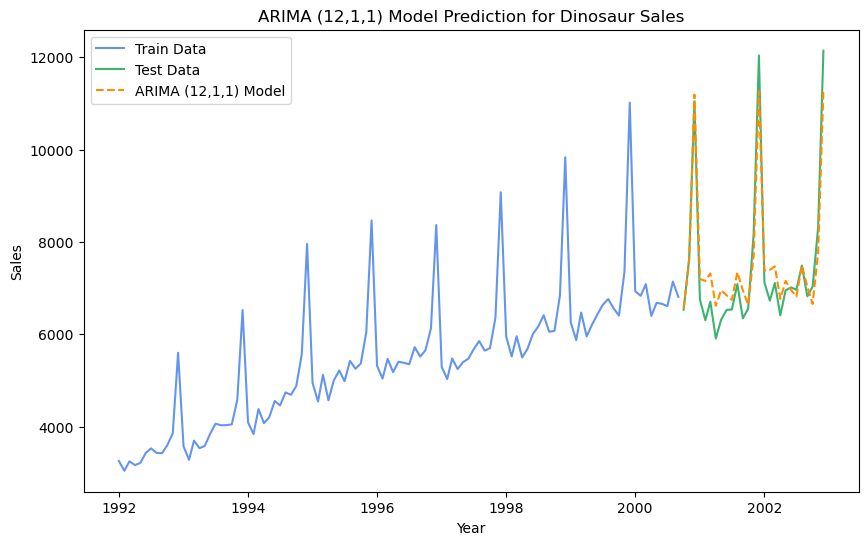

In [66]:
#Plot the arima model next to the original data with the 80/20 data split
test_training_model(train_data, test_data, test_predictions_arima_1,
                    'Year', 'Sales', 'ARIMA (12,1,1) Model Prediction for Dinosaur Sales','ARIMA (12,1,1) Model')

You can see that the ARIMA model has done a good job of understanding the data, however giving it an autoregressive value of 12 should be done a part of the SARIMA modeling which was discussed with Dr Burns. Let's look at the MAE.

In [67]:
#Get the mean absolute error
arima_1_mae = mean_absolute_error(test_data['Sales'],test_predictions_arima_1)
arima_1_mae

378.1747824813723

In [68]:
#Create a forecast model for the next 5 years for ARIMA (12,1,1)
#This will be modeled in the forecast section
forecast_arima_1 = model_arima_1.predict(start=test_data['Incrementing Month'][-1], end=test_data['Incrementing Month'][-1]+60, dynamic=False)

#### ARIMA (1,1,1) Modeling

In [69]:
# Fit ARIMA model to the training data
model_arima_2 = ARIMA(train_data['Sales'], order=(1, 1, 1))
model_arima_2 = model_arima_2.fit()

# Make predictions on the test data
test_predictions_arima_2 = model_arima_2.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

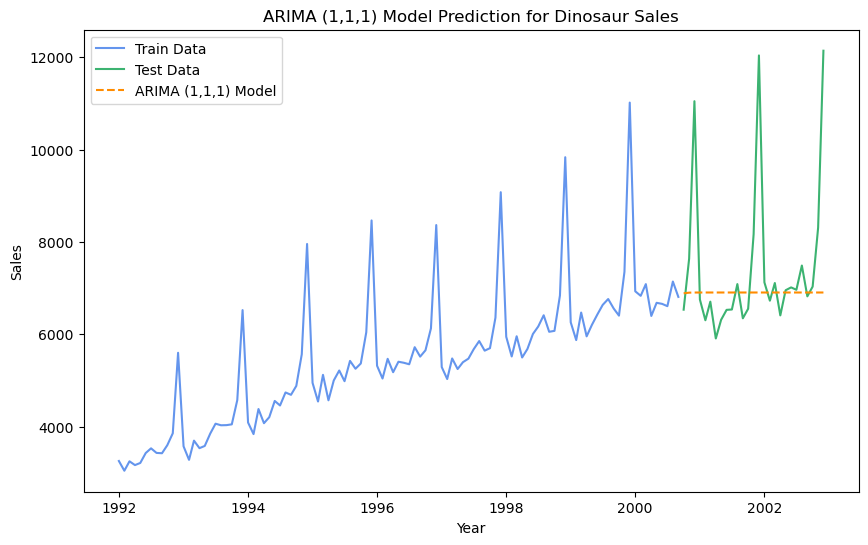

In [70]:
#Plot the arima model next to the original data with the 80/20 data split
test_training_model(train_data, test_data, test_predictions_arima_2,
                    'Year', 'Sales', 'ARIMA (1,1,1) Model Prediction for Dinosaur Sales', 'ARIMA (1,1,1) Model')

When you have a moving average, autoregressive and stationary difference of 1 then it is going to resemble a straight line as seen above. For this reason a SARIMA model is likely to perform much better.

In [71]:
#Get the mean absolute error
arima_2_mae = mean_absolute_error(test_data['Sales'],test_predictions_arima_2)
arima_2_mae

917.583286119831

The mae is reflective of the poor forecasting that has gone in fitting the model to the test data from the training data.

In [72]:
#Create a forecast model for the next 5 years
forecast_arima_2 = model_arima_2.predict(start=test_data['Incrementing Month'][-1], end=test_data['Incrementing Month'][-1]+60, dynamic=False)

#### SARIMA (0,1,2), (0,1,0,12) Model

In [73]:
# Fit SARIMA model to the training data
model_sarima_1 = SARIMAX(train_data['Sales'], order=(0,1,2), seasonal_order=(0, 1, 0, 12))
model_sarima_1 = model_sarima_1.fit()

# Make predictions on the test data
test_predictions_sarima_1 = model_sarima_1.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85988D+00    |proj g|=  3.37929D-02

At iterate    5    f=  5.85838D+00    |proj g|=  1.37952D-03

At iterate   10    f=  5.85730D+00    |proj g|=  1.82532D-02

At iterate   15    f=  5.85644D+00    |proj g|=  8.42748D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   8.427D-06   5.856D+00
  F =   5.8564439500917107     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


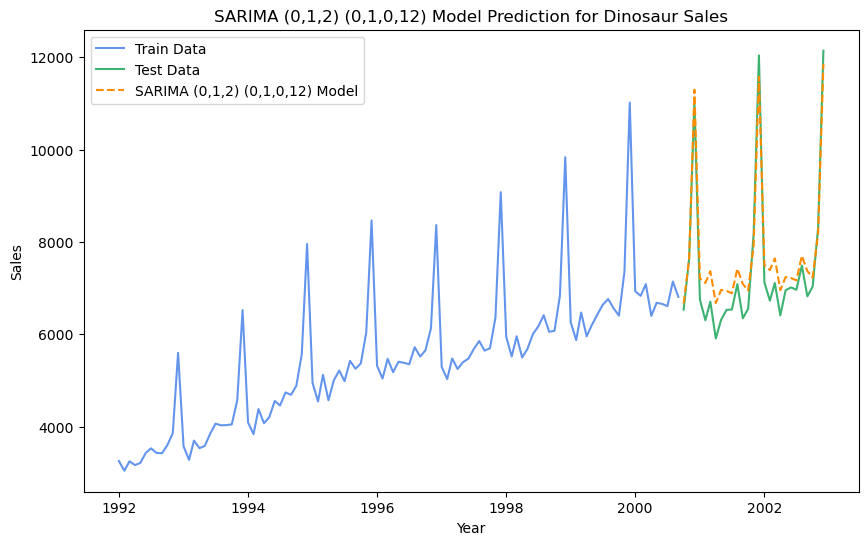

In [74]:
#Plot the arima model next to the original data with the 80/20 data split
test_training_model(train_data, test_data, test_predictions_sarima_1,
                    'Year', 'Sales', 'SARIMA (0,1,2) (0,1,0,12) Model Prediction for Dinosaur Sales','SARIMA (0,1,2) (0,1,0,12) Model')

In [75]:
#Get the mean absolute error
sarima_1_mae = mean_absolute_error(test_data['Sales'],test_predictions_sarima_1)
sarima_1_mae

401.85417090161354

The SARIMA model has done a good job of predicting the test data and that is reflected in the low mean absolute error.

In [76]:
#Forecast the model based off of the training data
forecast_sarima = model_sarima_1.predict(start=test_data['Incrementing Month'][-1], end=test_data['Incrementing Month'][-1]+60, dynamic=False)

#### MAE comparison

In [77]:
print(f'ARIMA (12,1,1) MAE: {arima_1_mae}')
print(f'ARIMA (1,1,1) MAE: {arima_2_mae}')
print(f'SARIMA (0,1,2) (0,1,0,12) MAE: {sarima_1_mae}')

ARIMA (12,1,1) MAE: 378.1747824813723
ARIMA (1,1,1) MAE: 917.583286119831
SARIMA (0,1,2) (0,1,0,12) MAE: 401.85417090161354


The ARIMA has the lowest mae but the spikes has been predicted more accurately for the SARIMA model. Let's look at the mean square error as it is going to penalise this and see how it differs.

#### MSE Comparison

In [78]:
#Find the mean squared error values
arima_1_mse = mean_squared_error(test_data['Sales'],test_predictions_arima_1)
arima_2_mse = mean_squared_error(test_data['Sales'],test_predictions_arima_2)
sarima_1_mse = mean_squared_error(test_data['Sales'],test_predictions_sarima_1)

In [79]:
#Print the mean squared error values
print(f'ARIMA (12,1,1) MSE: {arima_1_mse}')
print(f'ARIMA (1,1,1) MSE: {arima_2_mse}')
print(f'SARIMA (0,1,2) (0,1,0,12) MSE: {sarima_1_mse}')

ARIMA (12,1,1) MSE: 209355.7102029253
ARIMA (1,1,1) MSE: 2909209.5525103356
SARIMA (0,1,2) (0,1,0,12) MSE: 206827.38953059973


The SARIMA model is slightly lower than than the ARIMA model. However they are both very close to one another, they reflect the same thing effectively because of the higher AR value for the ARIMA model, which is why it is unnecessary and is more useful to just look at SARIMA models when the seasonality is that clear in the graph.

### Holt Winters Seasonal Method
This is commonly known as triple exponential smoothing and is used when the data exhibits seasonality. It incorporates SES, trend and seasonality which is why it is triple exponential smoothing.

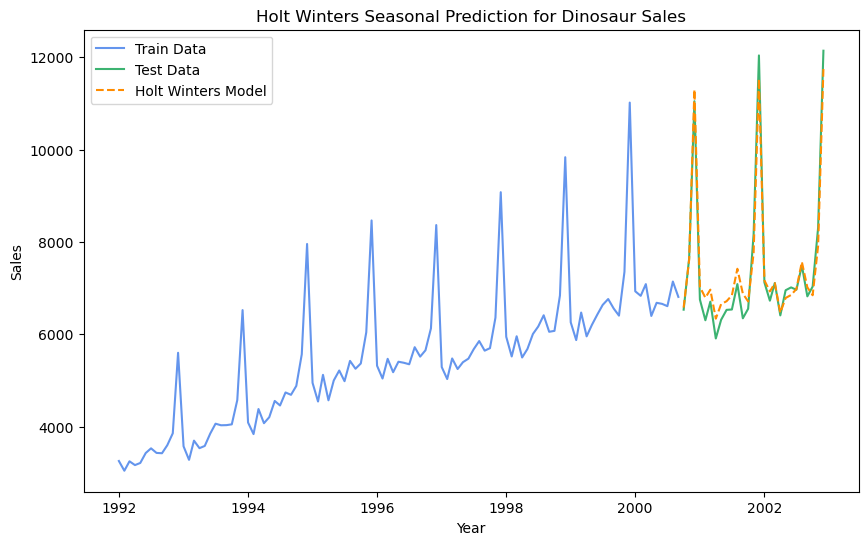

In [80]:
# Fit Holt-Winters method to the training data with multiplicative seasonality
holt_winters_1_model = ExponentialSmoothing(train_data['Sales'], seasonal_periods=12, trend='add', seasonal='mul')
holt_winters_1_model = holt_winters_1_model.fit(smoothing_level=0.5, smoothing_trend=0.2, smoothing_seasonal=0.7)

# Make predictions on the test data
holt_winters_test_predictions = holt_winters_1_model.predict(start=test_data.index[0], end=test_data.index[-1])

test_training_model(train_data, test_data, holt_winters_test_predictions,
                    'Year', 'Sales', 'Holt Winters Seasonal Prediction for Dinosaur Sales', 'Holt Winters Model')


In [81]:
#mae for Holt Winters Seasonal Method
holt_winters_mae = mean_absolute_error(test_data['Sales'],holt_winters_test_predictions)
holt_winters_mae

238.74855411408564

The mae is lower than those from the ARIMA and SARIMA model predictions. It is assumed that the Holt Winter's Forecast is going to be most accurate when lookingi nto the future.

In [82]:
# Make predictions based on the test data
forecast_holt_winters = holt_winters_1_model.predict(start=test_data['Incrementing Month'][-1], end=test_data['Incrementing Month'][-1]+60)

### 3. Seasonal Trend Modeling
This is going to look at what was explored in the trend section of the seasonal decomposition. There are two rates of growth, that at which the months 1-11 grow at and that at which month 12 grows at. Continuing the line of best fit for each different time period then incorporating them into one series should give decent insight into what is expected on average the future values to look like.

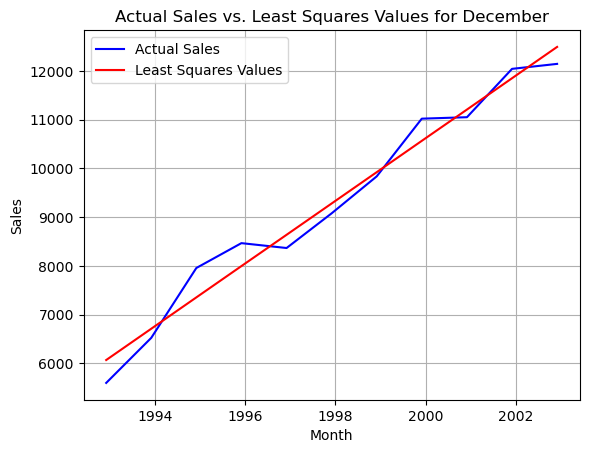

In [99]:
# Plot the actual December sales values
plt.plot(december_values['Sales'], label='Actual Sales', color='blue')

# Plot the least squares values for December
plt.plot(december_values['Least Squares Value December Values'], label='Least Squares Values', color='red')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual Sales vs. Least Squares Values for December')
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.show()

In [84]:
#Get the MAE of the December Values
#This is done by taking predicted less the least squares line
mae_december

313.08099173553705

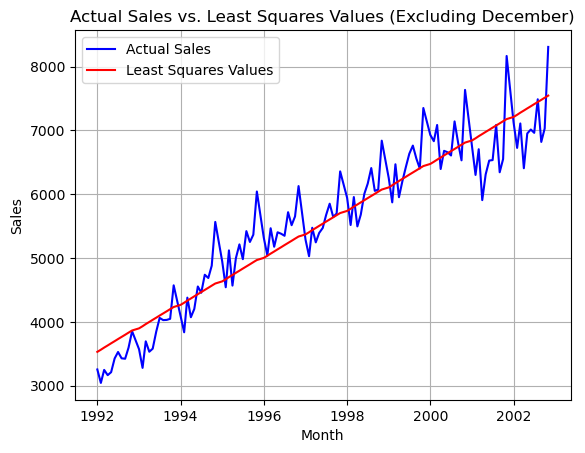

In [100]:
# Plot the actual sales values
plt.plot(dinosaur_no_december['Sales'], label='Actual Sales', color='blue')

# Plot the least squares values for the data excluding December
plt.plot(dinosaur_no_december['Least Squares Value No December'], label='Least Squares Values', color='red')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Actual Sales vs. Least Squares Values (Excluding December)')
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.show()

In [86]:
#Get the MAE of the data with out december included
#This is done by taking predicted less the least squares line
mae_no_december

320.78957385558857

#### MAE evaluation for different models
The goal from this is to determine which model would be expected to best predict the future results. 

In [87]:
#Print the output of the different mae and determine which will be most effective for forecasting based on train/test data split
print(f'mae for December predictions: {mae_december}')
print(f'mae for No December predictions: {mae_no_december}')
print(f'mae of original least squares line: {mae_original}')
print(f'mae ARIMA (12,1,1): {arima_1_mae}')
print(f'mae ARIMA (1,1,1): {arima_2_mae}')
print(f'mae SARIMA (0,1,2) (0,1,0,12): {sarima_1_mae}')
print(f'mae Holt Winters: {holt_winters_mae}')

mae for December predictions: 313.08099173553705
mae for No December predictions: 320.78957385558857
mae of original least squares line: 649.2980631109032
mae ARIMA (12,1,1): 378.1747824813723
mae ARIMA (1,1,1): 917.583286119831
mae SARIMA (0,1,2) (0,1,0,12): 401.85417090161354
mae Holt Winters: 238.74855411408564


The most effective modeling seems to be:
1. Linear Trend Method (mae for December/no December)
2. SARIMA (0,1,2) (0,1,0,12)
3. Holt Winter's Seasonal Method

These are going to be explored in the forecasting section

### 1.5 Forecasting
Forecast the next 5 years of data

#### 1. Linear Trend Modeling 
Use the slope and intercept to predict 5 years out

##### December Values Linear Model

In [88]:
#Create a new dataframe that predicts the next 5 years of data with predictions
forecast_december = pd.DataFrame()

#Creating an incrementing year columns that is going to be multiplied by slope and added to intercept
#Have the range be from 12 onways as there was 11 years of data before
forecast_december['Incrementing Year'] = range(12,17)

#Create a date column so add to the overall dataframe below for predictions
forecast_december['Date'] = pd.date_range(start='2003-12-01',periods=5,freq='12M')
forecast_december['Date'] = forecast_december['Date'] - pd.Timedelta(days=30)

#Set the index to 'Date' column
forecast_december.set_index('Date',inplace=True)

#Predict sales
forecast_december['Predicted Sales'] = intercept_december_values + (slope_december_values*forecast_december['Incrementing Year'])
forecast_december

,Incrementing Year,Predicted Sales
Date,,
2003-12-01,12,13134.418182
2004-12-01,13,13776.836364
2005-12-01,14,14419.254545
2006-12-01,15,15061.672727
2007-12-01,16,15704.090909


##### No December Value Linear Model

In [89]:
#Create a new dataframe which finds the monthly values for the next 5 years
linear_forecast = pd.DataFrame()

#Create an incrementing month column where the 12th value is an NaN
linear_forecast['Incrementing Month'] = range(133,194)

#Include a date going from 2002-01-01 to 2006-12-01
linear_forecast['Date'] = pd.date_range(start='2003-01-01',periods=len(linear_forecast),freq='M')

#Adjust the date so it is at the start of each month not the end
linear_forecast['Date'] = linear_forecast['Date'] - pd.offsets.MonthBegin(1)

linear_forecast['Predicted Sales'] = None

#Make every values of month 1-11 from 
linear_forecast['Predicted Sales'] = intercept_no_december + slope_no_december*linear_forecast['Incrementing Month']

#Set the index to date so that the dataframe fits the needs of the function
linear_forecast.set_index('Date',inplace=True)

#Add the december values
linear_forecast['Predicted Sales'].iloc[11::12] = forecast_december['Predicted Sales']

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_31805/3321590240.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_forecast['Predicted Sales'].iloc[11::12] = forecast_december['Predicted Sales']


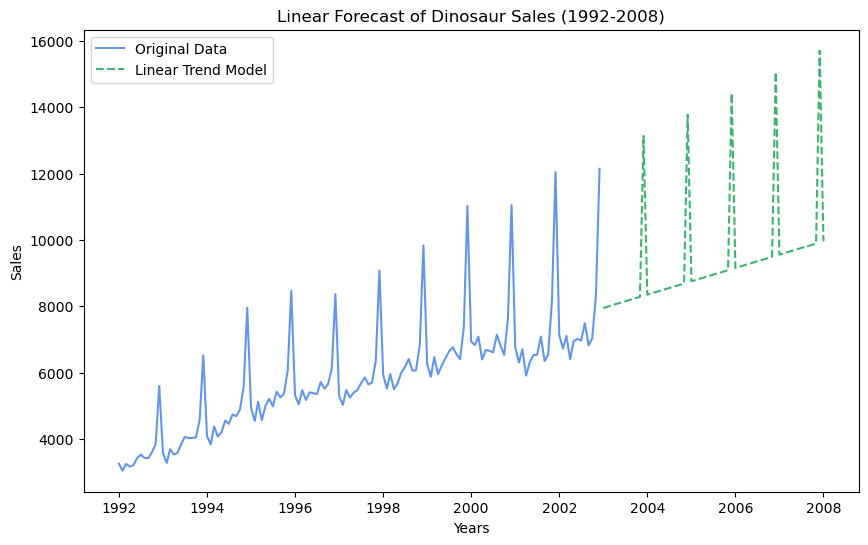

In [90]:
#Plot the prediction of dinosaur sales from 2003-2008 based on the 
model_forecast(dinosaur,dinosaur['Sales'],linear_forecast['Predicted Sales'],'Years','Sales','Linear Forecast of Dinosaur Sales (1992-2008)','Linear Trend Model')

#### 2. SARIMA (0,1,2) (0,1,0,12) Forecast

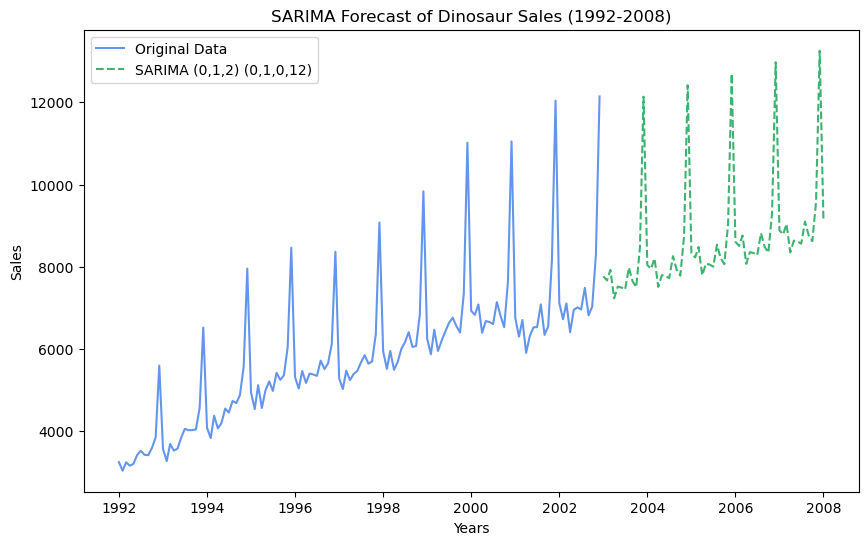

In [91]:
#Forecast SARIMA model
model_forecast(dinosaur,dinosaur['Sales'],forecast_sarima,'Years','Sales','SARIMA Forecast of Dinosaur Sales (1992-2008)','SARIMA (0,1,2) (0,1,0,12)')

#### 3. Holt Winter's Seasonal Method Forecast

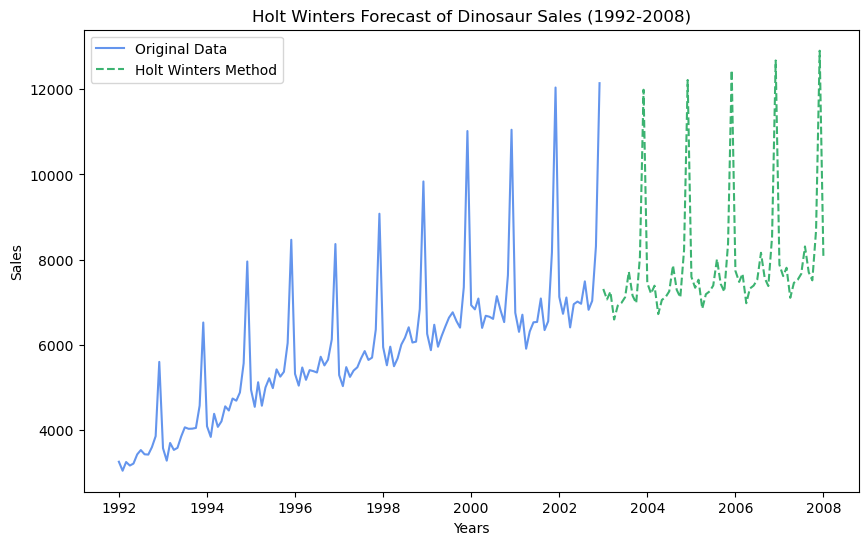

In [92]:
#Forecast Holt Winter's Seasonal Method
model_forecast(dinosaur,dinosaur['Sales'],forecast_holt_winters,'Years','Sales','Holt Winters Forecast of Dinosaur Sales (1992-2008)','Holt Winters Method')

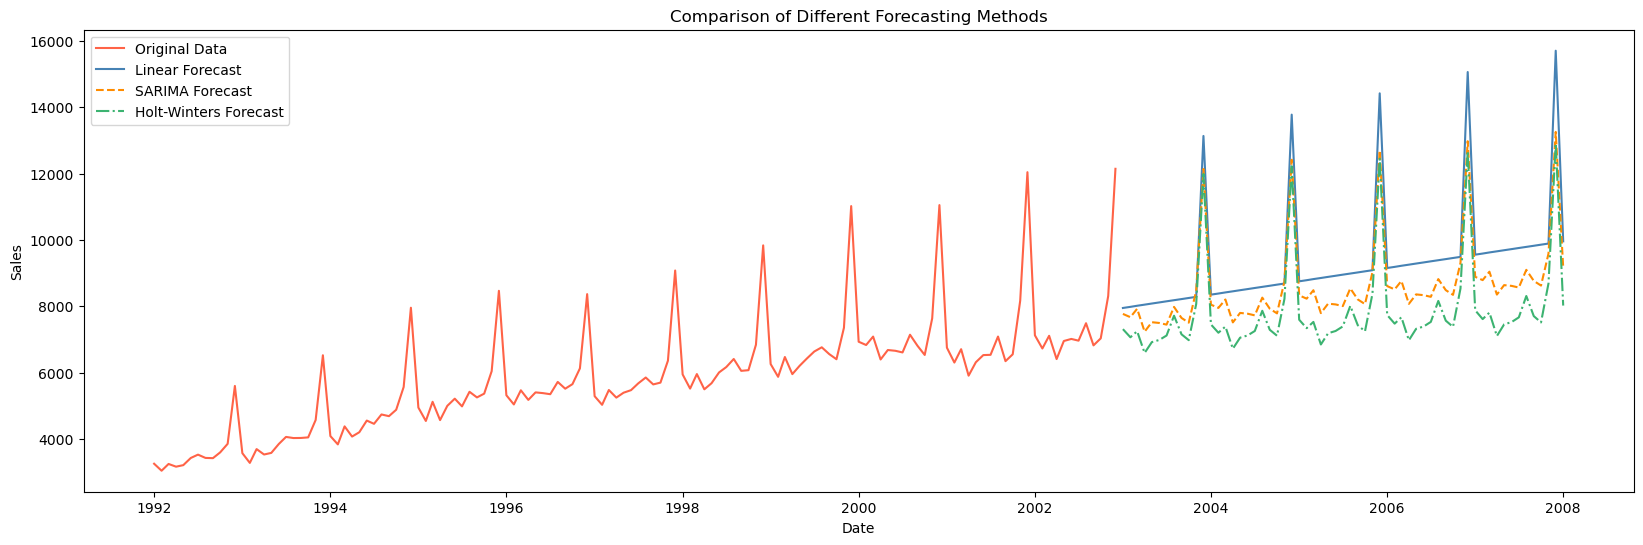

In [93]:
import matplotlib.pyplot as plt

# Plot the original data
plt.figure(figsize=(20, 6))
plt.plot(dinosaur.index, dinosaur['Sales'], color='tomato', label='Original Data')

# Plot the forecasts with different colors and line styles
plt.plot(linear_forecast.index, linear_forecast['Predicted Sales'], linestyle='-', color='steelblue', label='Linear Forecast')
plt.plot(forecast_sarima, linestyle='--', color='darkorange', label='SARIMA Forecast')
plt.plot(forecast_holt_winters, linestyle='-.', color='mediumseagreen', label='Holt-Winters Forecast')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Different Forecasting Methods')

# Add legend
plt.legend()

# Show plot
plt.show()

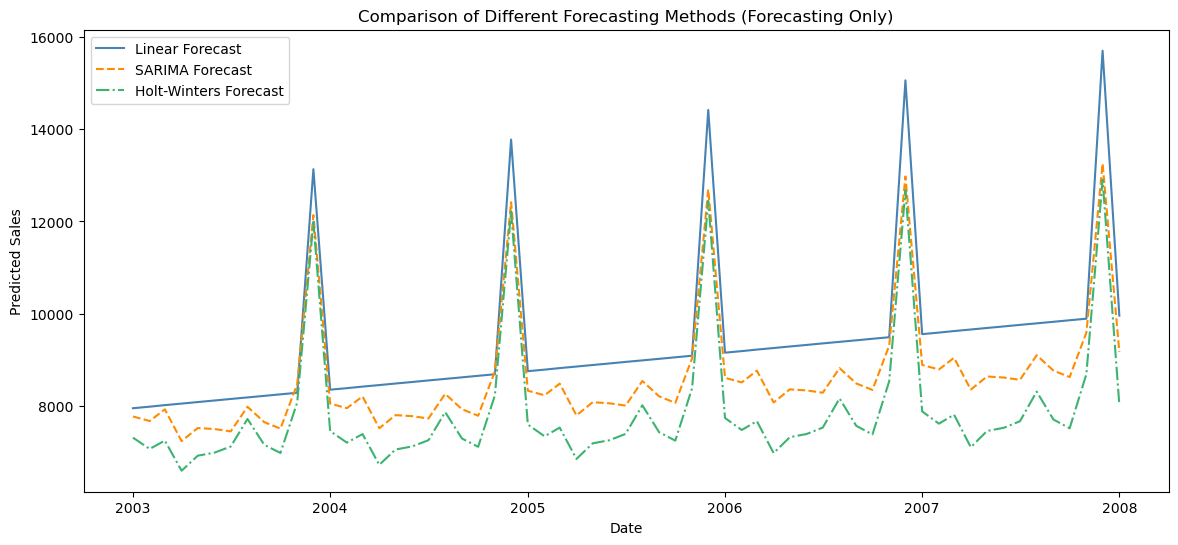

In [101]:
# Plot the forecasts with different colors and line styles
plt.figure(figsize=(14,6))
plt.plot(linear_forecast.index, linear_forecast['Predicted Sales'], linestyle='-', color='steelblue', label='Linear Forecast')
plt.plot(forecast_sarima, linestyle='--', color='darkorange', label='SARIMA Forecast')
plt.plot(forecast_holt_winters, linestyle='-.', color='mediumseagreen', label='Holt-Winters Forecast')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.title('Comparison of Different Forecasting Methods (Forecasting Only)')

# Add legend
plt.legend()

# Show plot
plt.show()
